Uses digit data from http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2005_Robust_Reading_Competitions

# Load Data and Split

In [1]:
import struct
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
# a function for reading mnist-format files

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
# read image and label files

digits = read_idx('data/digit_images.bin')
labels = read_idx('data/digit_labels.bin')

digits.shape, labels.shape

((988, 28, 28), (988,))

In [4]:
print(len(np.unique(labels)), [l for l in np.unique(labels)])

10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


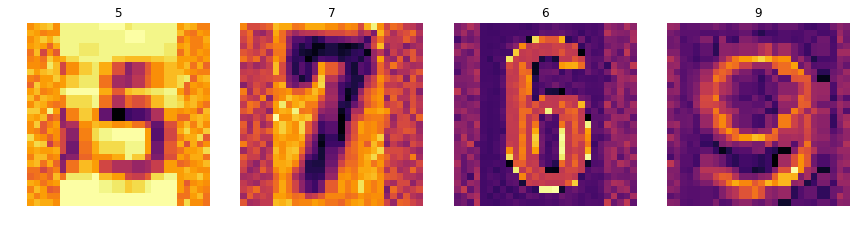

In [5]:
# run multiple times to see different images

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,12))

for ax in axes:
    idx = np.random.randint(0, len(digits))
    ax.imshow(digits[idx], cmap ='inferno')
    ax.set_title(labels[idx])
    ax.axis('off')
    
fig.tight_layout()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [7]:
# one-hot-encode labels and reshape images
labels_ohe = OneHotEncoder(categories='auto').fit_transform(labels[..., None])
digits = digits[..., None]

X_train, X_test, y_train, y_test = train_test_split(digits, labels_ohe)

# Make Keras Model

In [384]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, InputLayer, Flatten, MaxPool2D, BatchNormalization

In [402]:
def build_model(n_classes=10):

    droprate = 0.25

    model = Sequential()
    model.add(InputLayer(input_shape=(28, 28, 1)))

    model.add(Conv2D(16, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Conv2D(16, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer='l2'))
    

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()
    
    return model

In [403]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_177 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
dropout_124 (Dropout)        (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_125 (Dropout)        (None, 14, 14, 16)        0         
__________

In [404]:
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Train on 741 samples, validate on 247 samples
Epoch 1/50
741/741 [==============================] - 4s 5ms/step - loss: 3.8427 - acc: 0.1727 - val_loss: 3.2878 - val_acc: 0.2267
Epoch 2/50
741/741 [==============================] - 1s 854us/step - loss: 3.3153 - acc: 0.2443 - val_loss: 3.1436 - val_acc: 0.2389
Epoch 3/50
741/741 [==============================] - 1s 859us/step - loss: 3.0756 - acc: 0.2874 - val_loss: 3.0286 - val_acc: 0.2591
Epoch 4/50
741/741 [==============================] - 1s 857us/step - loss: 2.8698 - acc: 0.3482 - val_loss: 2.8947 - val_acc: 0.2955
Epoch 5/50
741/741 [==============================] - 1s 863us/step - loss: 2.7383 - acc: 0.3657 - val_loss: 2.8224 - val_acc: 0.3441
Epoch 6/50
741/741 [==============================] - 1s 850us/step - loss: 2.5648 - acc: 0.4413 - val_loss: 2.6891 - val_acc: 0.3765
Epoch 7/50
741/741 [==============================] - 1s 864us/step - loss: 2.4090 - acc: 0.4980 - val_loss: 2.5673 - val_acc: 0.4575
Epoch 8/50
741/741

In [405]:
history = model.fit(X_train, y_train, batch_size=64, epochs=25, validation_data=(X_test, y_test))

Train on 741 samples, validate on 247 samples
Epoch 1/25
741/741 [==============================] - 0s 261us/step - loss: 0.7176 - acc: 0.9312 - val_loss: 1.3934 - val_acc: 0.7166
Epoch 2/25
741/741 [==============================] - 0s 237us/step - loss: 0.7250 - acc: 0.9271 - val_loss: 1.3813 - val_acc: 0.7328
Epoch 3/25
741/741 [==============================] - 0s 226us/step - loss: 0.6393 - acc: 0.9595 - val_loss: 1.3259 - val_acc: 0.7449
Epoch 4/25
741/741 [==============================] - 0s 228us/step - loss: 0.6646 - acc: 0.9447 - val_loss: 1.3100 - val_acc: 0.7571
Epoch 5/25
741/741 [==============================] - 0s 231us/step - loss: 0.6431 - acc: 0.9487 - val_loss: 1.3293 - val_acc: 0.7328
Epoch 6/25
741/741 [==============================] - 0s 228us/step - loss: 0.6284 - acc: 0.9487 - val_loss: 1.3093 - val_acc: 0.7328
Epoch 7/25
741/741 [==============================] - 0s 228us/step - loss: 0.5989 - acc: 0.9622 - val_loss: 1.2684 - val_acc: 0.7611
Epoch 8/25
741/7

In [406]:
preds = model.predict(X_test)

In [407]:
preds_cat = np.argmax(preds, axis=-1)
labs_cat = np.argmax(y_test, axis=-1).squeeze()

In [408]:
np.mean(preds_cat == labs_cat)

0.6963562753036437

# Evaluate on New Image

In [409]:
import cv2

In [500]:
def predict_on_file(filename, model):
    img = cv2.imread(filename)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_grey, dsize=(28,28))

    prediction = model.predict(img_resized[None, ..., None])[0]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    
    axes[0].imshow(img);
    axes[0].axis('off')
    axes[0].set_title('Original')

    axes[1].imshow(img_resized, cmap='gray');
    axes[1].axis('off')
    axes[1].set_title('Input to Model')

    
    axes[2].bar(x=range(0,10), height=prediction)
    axes[2].xaxis.set_ticks(np.arange(0, 10, 1))
    axes[2].set_title('Prediction: {}'.format(np.argmax(prediction)))
    axes[2].axvline(np.argmax(prediction), c='red')
    
    plt.tight_layout()
    
    return prediction

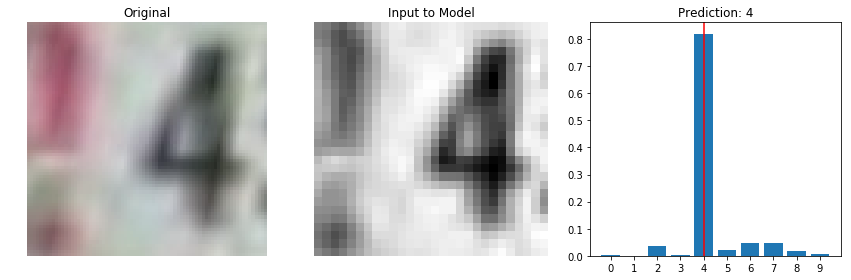

In [501]:
a1 = predict_on_file('test_images/4.png', model)

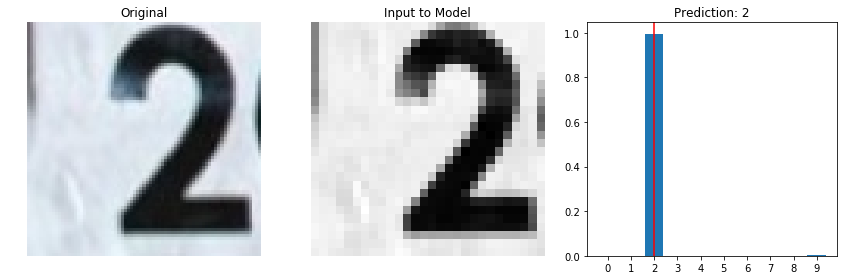

In [502]:
a2 = predict_on_file('test_images/2.png', model)

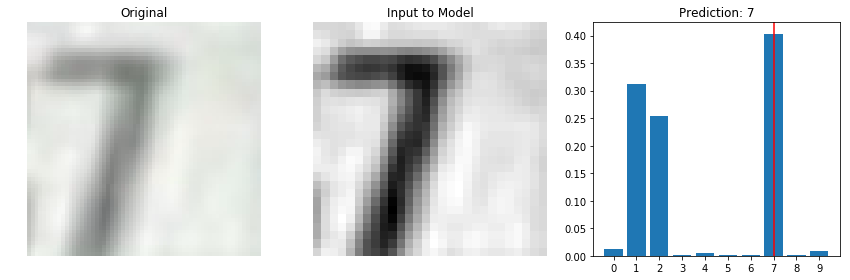

In [503]:
a3 = predict_on_file('test_images/7.png', model)